In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def readFileAsArr(fileName, source):
    res = []
    file = open('./data/4ms/' + fileName, encoding="utf8").read()
    for ind, line in enumerate(file.split('\n')):
        if ind < 100:
            continue
        if line == '':
            continue
        splitLine = line.split(",")
        res.append([source, splitLine[0], splitLine[1], float(splitLine[2])])
    return res

latencies = readFileAsArr('plumber.txt', 'Plumber')
latencies = latencies + readFileAsArr('baseline.txt', 'Baseline')
latencies = latencies + readFileAsArr('dapr.txt', 'Dapr')

In [3]:
df = pd.DataFrame(latencies, columns=['Platform', 'Begin nano', 'End nano', 'Latency (ms)'])

In [4]:
df.groupby(["Platform"]).describe()


Latency (ms)                                                    \
                count      mean       std       min       25%       50%   
Platform                                                                  
Baseline      43058.0  1.880104  2.324621  1.045455  1.623847  1.744399   
Dapr          43058.0  1.992718  2.391436  1.232350  1.735044  1.850888   
Plumber       43058.0  2.223082  2.594888  1.399530  1.935509  2.055654   

                                
               75%         max  
Platform                        
Baseline  1.869660  103.873129  
Dapr      1.967861  104.015828  
Plumber   2.177586  104.110245

In [5]:
df.head()

,Platform,Begin nano,End nano,Latency (ms)
0,Plumber,1630057845085880261,1630057845088111177,2.230916
1,Plumber,1630057845090565931,1630057845092872335,2.306404
2,Plumber,1630057845095370525,1630057845097585717,2.215192
3,Plumber,1630057845100149057,1630057845102317269,2.168212
4,Plumber,1630057845104881173,1630057845107161976,2.280803


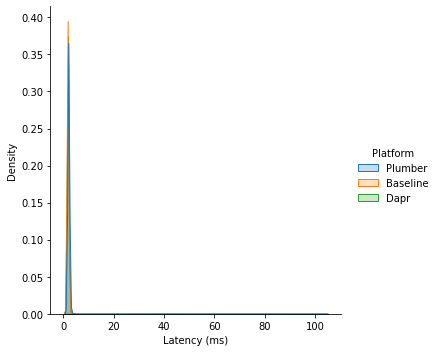

In [6]:
sns.displot(df, x="Latency (ms)", hue="Platform", kind="kde", fill=True)

In [7]:
df.describe()

,Latency (ms)
count,129174.000000
mean,2.031968
std,2.443844
min,1.045455
25%,1.730498
50%,1.879978
75%,2.038346
max,104.110245


<AxesSubplot:xlabel='Platform', ylabel='Latency (ms)'>

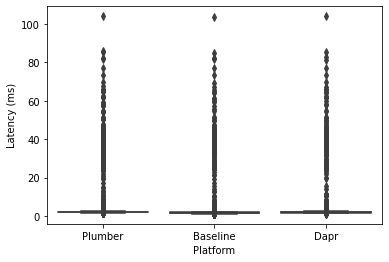

In [8]:
sns.boxplot(data=df, x="Platform", y="Latency (ms)")

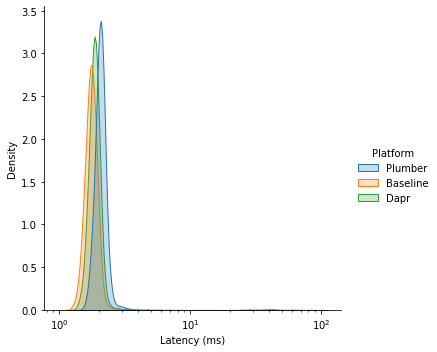

In [10]:
sns.displot(df, x="Latency (ms)", hue="Platform", kind="kde", fill=True, log_scale=True)

<AxesSubplot:xlabel='Latency (ms)', ylabel='Proportion'>

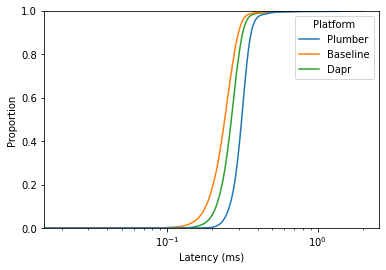

In [9]:
sns.ecdfplot(data=df, x="Latency (ms)", hue="Platform", log_scale=True)

In [10]:
df.shape

(129174, 4)

In [11]:
# Obvious issue with outliers for visualizations: remove them through IQR method
plat_dfs = []
for plat in df["Platform"].unique():
    print(plat)
    df_plat = df[df["Platform"] == plat]
    q1 = df_plat.quantile(0.25)["Latency (ms)"]
    q3 = df_plat.quantile(0.75)["Latency (ms)"]
    iqr = q3 - q1
    print(df_plat.shape)
    df_plat = df_plat[~((df["Latency (ms)"] < (q1 - 1.5 * iqr)) | (df["Latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)
    print(df_plat.shape)
    plat_dfs.append(df_plat)

filtered_df = pd.concat(plat_dfs)


Plumber
(43058, 4)
(41781, 4)
Baseline
(43058, 4)
(42284, 4)
Dapr
(43058, 4)
(42077, 4)


<ipython-input-11-cb4ad0cf4b78>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plat = df_plat[~((df["Latency (ms)"] < (q1 - 1.5 * iqr)) | (df["Latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)
<ipython-input-11-cb4ad0cf4b78>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plat = df_plat[~((df["Latency (ms)"] < (q1 - 1.5 * iqr)) | (df["Latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)
<ipython-input-11-cb4ad0cf4b78>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plat = df_plat[~((df["Latency (ms)"] < (q1 - 1.5 * iqr)) | (df["Latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)


In [12]:
filtered_df.groupby(["Platform"]).describe()

Latency (ms)                                                    \
                count      mean       std       min       25%       50%   
Platform                                                                  
Baseline      42284.0  1.743099  0.174522  1.255710  1.621962  1.740861   
Dapr          42077.0  1.847020  0.167068  1.386305  1.733429  1.847174   
Plumber       41781.0  2.049419  0.175568  1.572552  1.932626  2.050345   

                              
               75%       max  
Platform                      
Baseline  1.862416  2.238354  
Dapr      1.959343  2.317063  
Plumber   2.166286  2.540405

In [13]:
# preprocessing for catplot
df_metrics = pd.DataFrame(columns=["Metric", "Platform", "Latency (ms)"])
for plat in df["Platform"].unique():
    plat_df = df[df["Platform"] == plat]
    df_metrics = df_metrics.append({"Metric": "Median", "Platform": plat, "Latency (ms)": plat_df.quantile(0.5)["Latency (ms)"]}, ignore_index=True) 
    df_metrics = df_metrics.append({"Metric": "90th Percentile", "Platform": plat, "Latency (ms)": plat_df.quantile(0.9)["Latency (ms)"]}, ignore_index=True) 
    df_metrics = df_metrics.append({"Metric": "99th Percentile", "Platform": plat, "Latency (ms)": plat_df.quantile(0.99)["Latency (ms)"]}, ignore_index=True) 

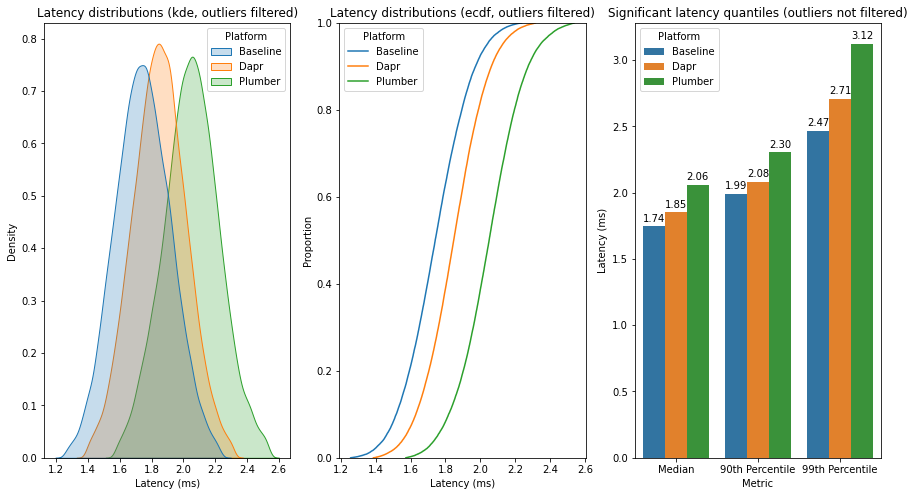

In [14]:

f, axes = plt.subplots(1, 3, figsize=(15,8))
h_order = ["Baseline", "Dapr", "Plumber"]
sns.kdeplot(data=filtered_df, x="Latency (ms)", hue="Platform", fill=True, ax=axes[0], hue_order=h_order)
sns.ecdfplot(data=filtered_df, x="Latency (ms)", hue="Platform", ax=axes[1], hue_order=h_order)
sns.barplot(
    data=df_metrics,
    x="Metric", y="Latency (ms)", hue="Platform",
    hue_order=h_order,
    ax = axes[2]
)

axes[0].title.set_text('Latency distributions (kde, outliers filtered)')
axes[1].title.set_text('Latency distributions (ecdf, outliers filtered)')
axes[2].title.set_text('Significant latency quantiles (outliers not filtered)')


def add_value_labels(ax, spacing=3):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(axes[2])


In [ ]:
df = df.astype({'Begin nano': 'int64'})
delta_s = (df["Begin nano"].max() - df["Begin nano"].min()) / 1_000_000_000
tot_messages = len(df.index) / 3
tot_messages / delta_s

In [11]:
df.groupby(["Platform"]).sem()

,Latency (ms)
Platform,
Baseline,0.011203
Dapr,0.011525
Plumber,0.012505
